# 06 - Spotify Audio Features Exploratory Data Analysis

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation, KernelPCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

sns.set(context='poster', style='white')
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

artist_all     artist_base  rank              song  year  \
280   walter brennan  walter brennan    81        old rivers  1962   
664    david houston   david houston    65  almost persuaded  1966   
1500    the spinners    the spinners   100       mighty love  1974   

     artist_featured        song_clean    artist_clean  \
280              NaN        old rivers  walter brennan   
664              NaN  almost persuaded   david houston   
1500             NaN       mighty love    the spinners   

                                                 lyrics  acousticness  \
280    words and music by crofford how old was i whe...         0.842   
664   last night all alone in a barroom met a girl w...         0.897   
1500  once there was a boy and girl boy said i love ...         0.585   

       ...     key  liveness  loudness  mode  popularity  release_date  \
280    ...     9.0     0.145   -11.705   1.0        20.0    2012-04-20   
664    ...     8.0     0.102   -15.202   1.0        25.0          1972   
1500   ...     7.0     0.477   -10.746   1.0        12.0    2018-05-05   

      speechiness    tempo  time_signature  valence  
280        0.0768  118.953             4.0    0.678  
664        0.0332  132.243             5.0    0.334  
1500       0.0541  110.497             4.0    0.718  

[3 rows x 25 columns]

## Pre-processing

In [3]:
df['artist_clean'] = df['artist_clean'].replace('beyonce knowles', 'beyonce')

# remove duplicate songs
df = df.drop_duplicates(subset=['artist_clean', 'song_clean'], keep='first')

# strip whitespace at beginning and ends of artist columns
artist_cols = ['artist_base', 'artist_all', 'artist_featured', 'artist_clean']
df[artist_cols] = df[artist_cols].applymap(
    lambda x: x.strip() if not isinstance(x, float) else np.nan)
df.shape

(5566, 25)

In [4]:
def clean_lyrics(x):
    if isinstance(x, float):
        return np.nan
    x = x.replace('outro', '')
    x = x.replace('bridge', '')
    x = x.replace('instrumental', '')
    return x

df['lyrics'] = df['lyrics'].apply(clean_lyrics)

In [5]:
df['duration_min'] = df['duration_ms'] / 1000 / 60
df = df.drop('duration_ms', axis=1)

## Univariate distributions

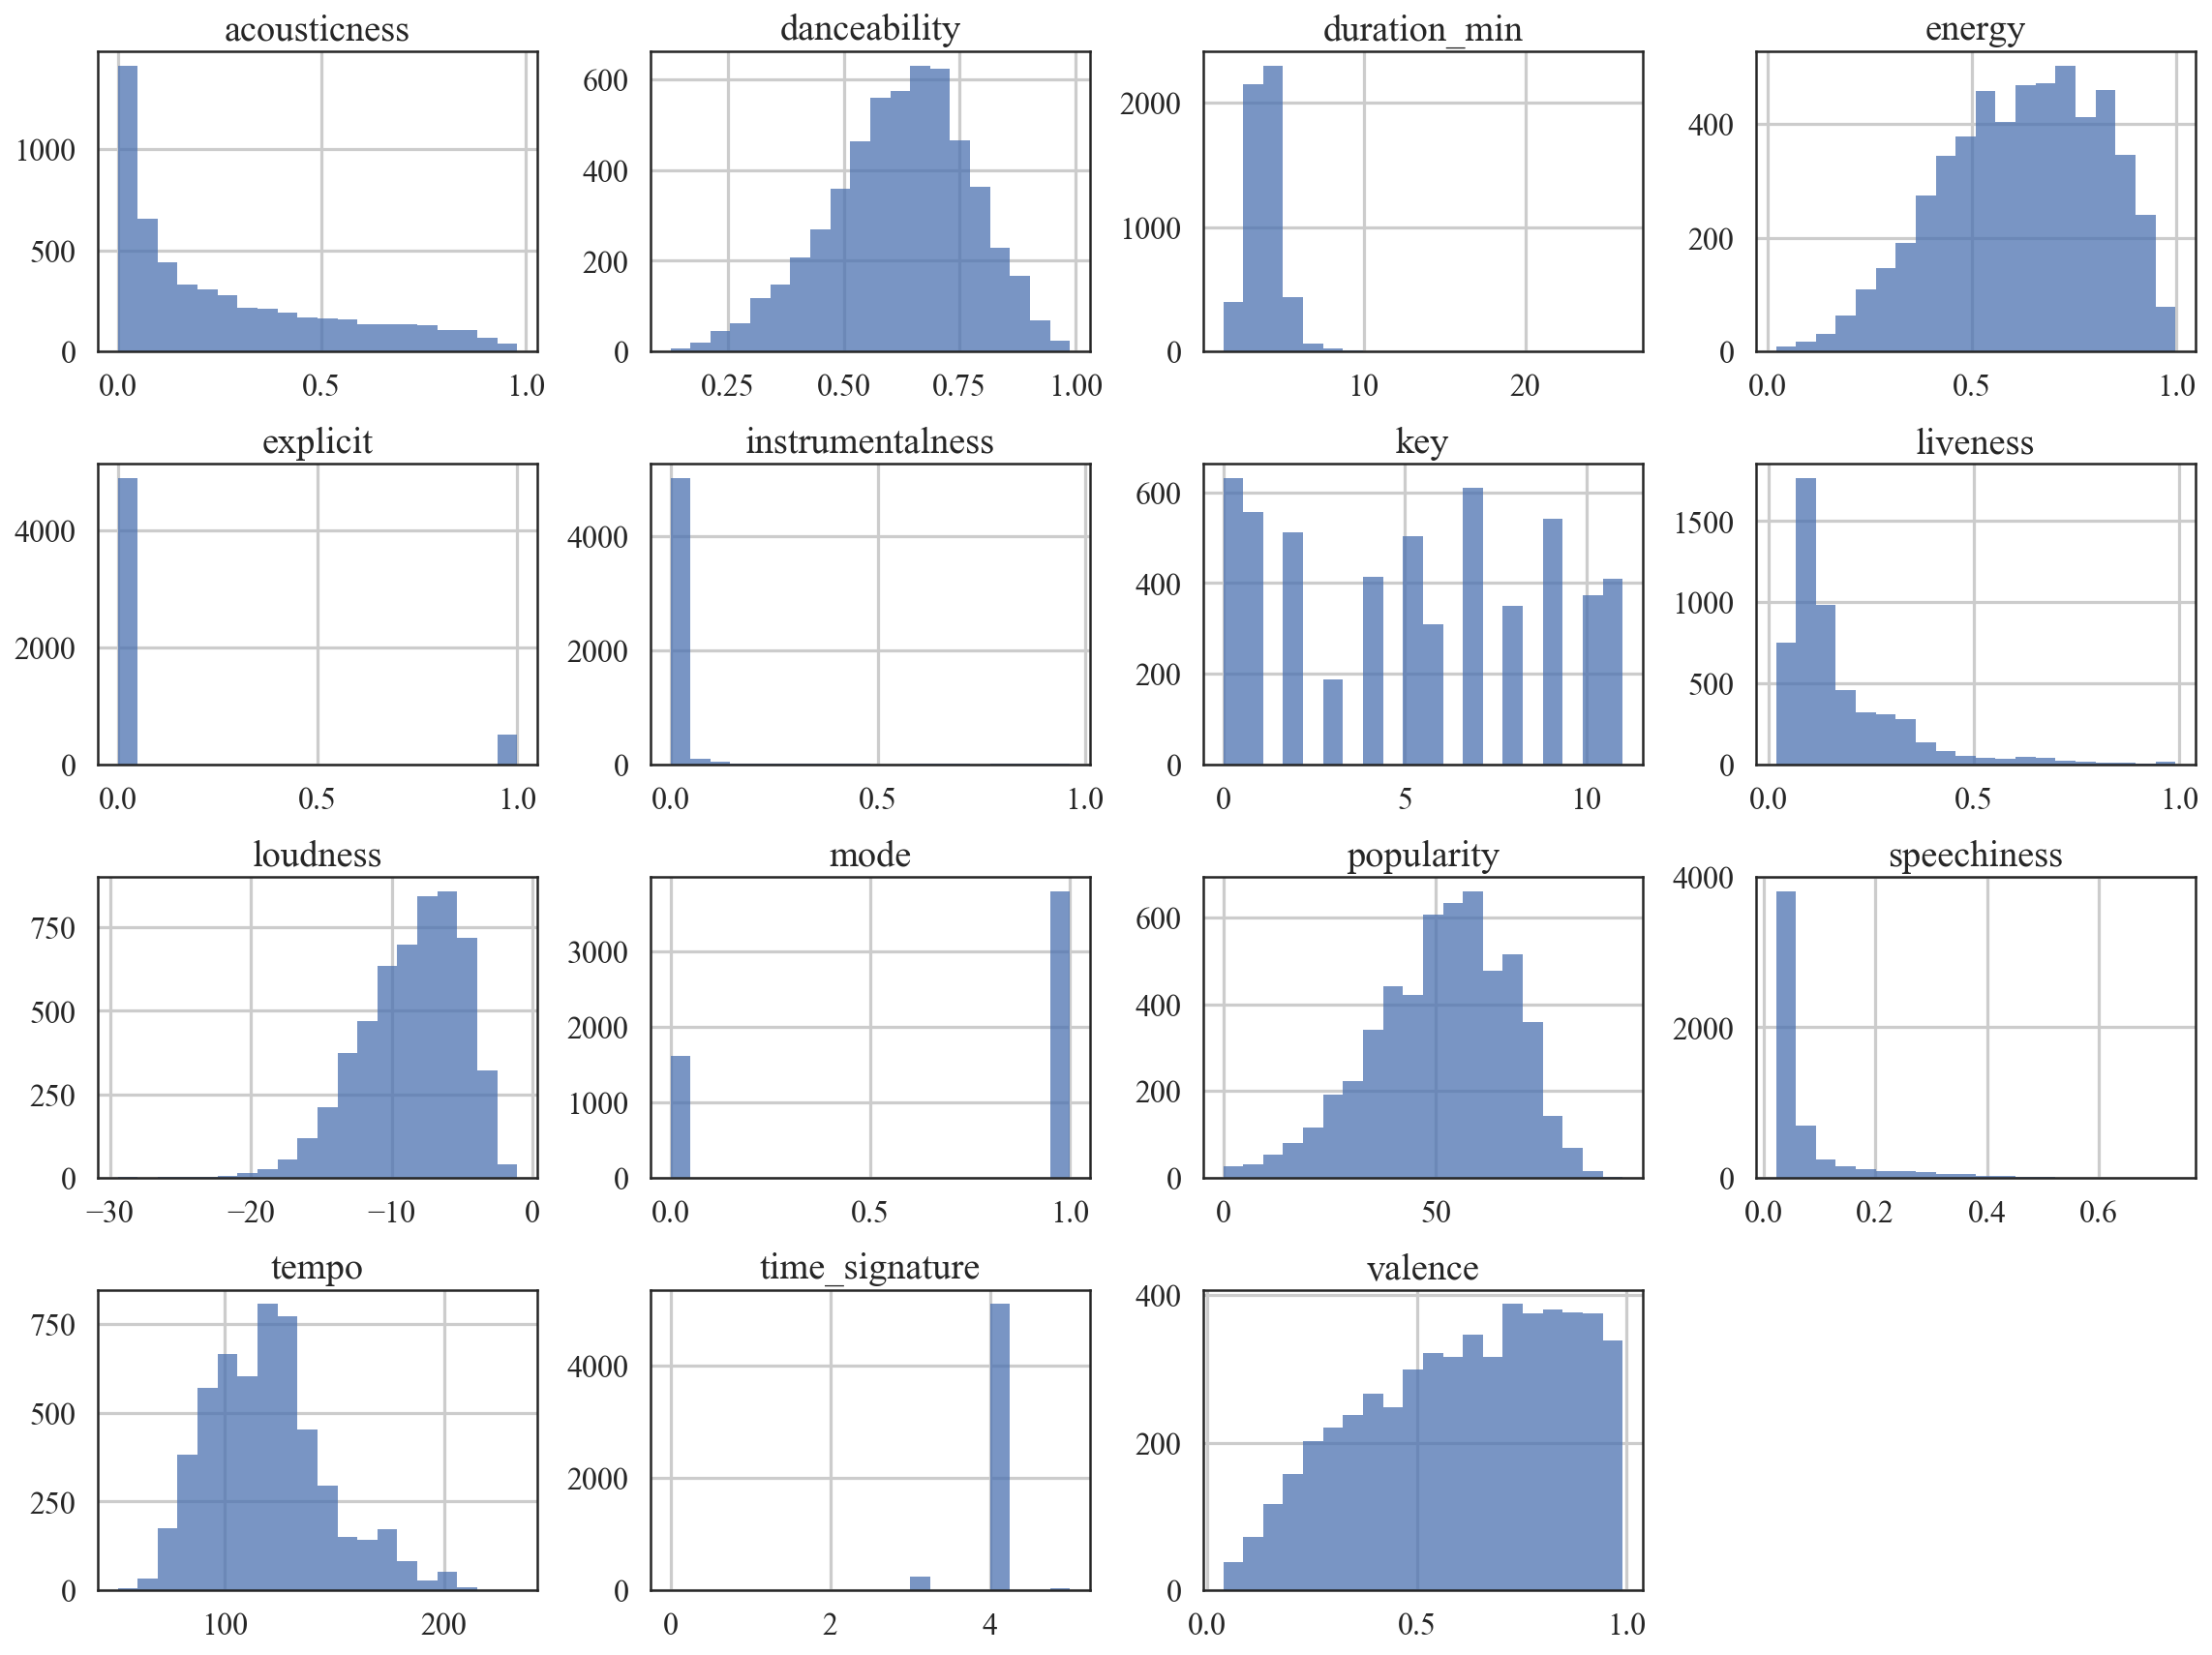

In [15]:
df.drop(['year', 'rank'], axis=1).hist(figsize=(16,12), bins=20, alpha=0.75);
plt.tight_layout()

In [160]:
df[df['duration_min'] > 20]

artist_all    artist_base  rank           song  year artist_featured  \
1479  mike oldfield  mike oldfield    79  tubular bells  1974             NaN   

         song_clean   artist_clean  \
1479  tubular bells  mike oldfield   

                                                 lyrics  acousticness  \
1479  spoken grand piano reed and pipe organ glocken...         0.558   

         ...       liveness  loudness  mode  popularity  release_date  \
1479     ...          0.111   -19.087   0.0        33.0    1973-02-01   

      speechiness    tempo  time_signature  valence duration_min  
1479       0.0364  103.516             4.0   0.0574    26.018883  

[1 rows x 25 columns]

## Correlation heatmap 

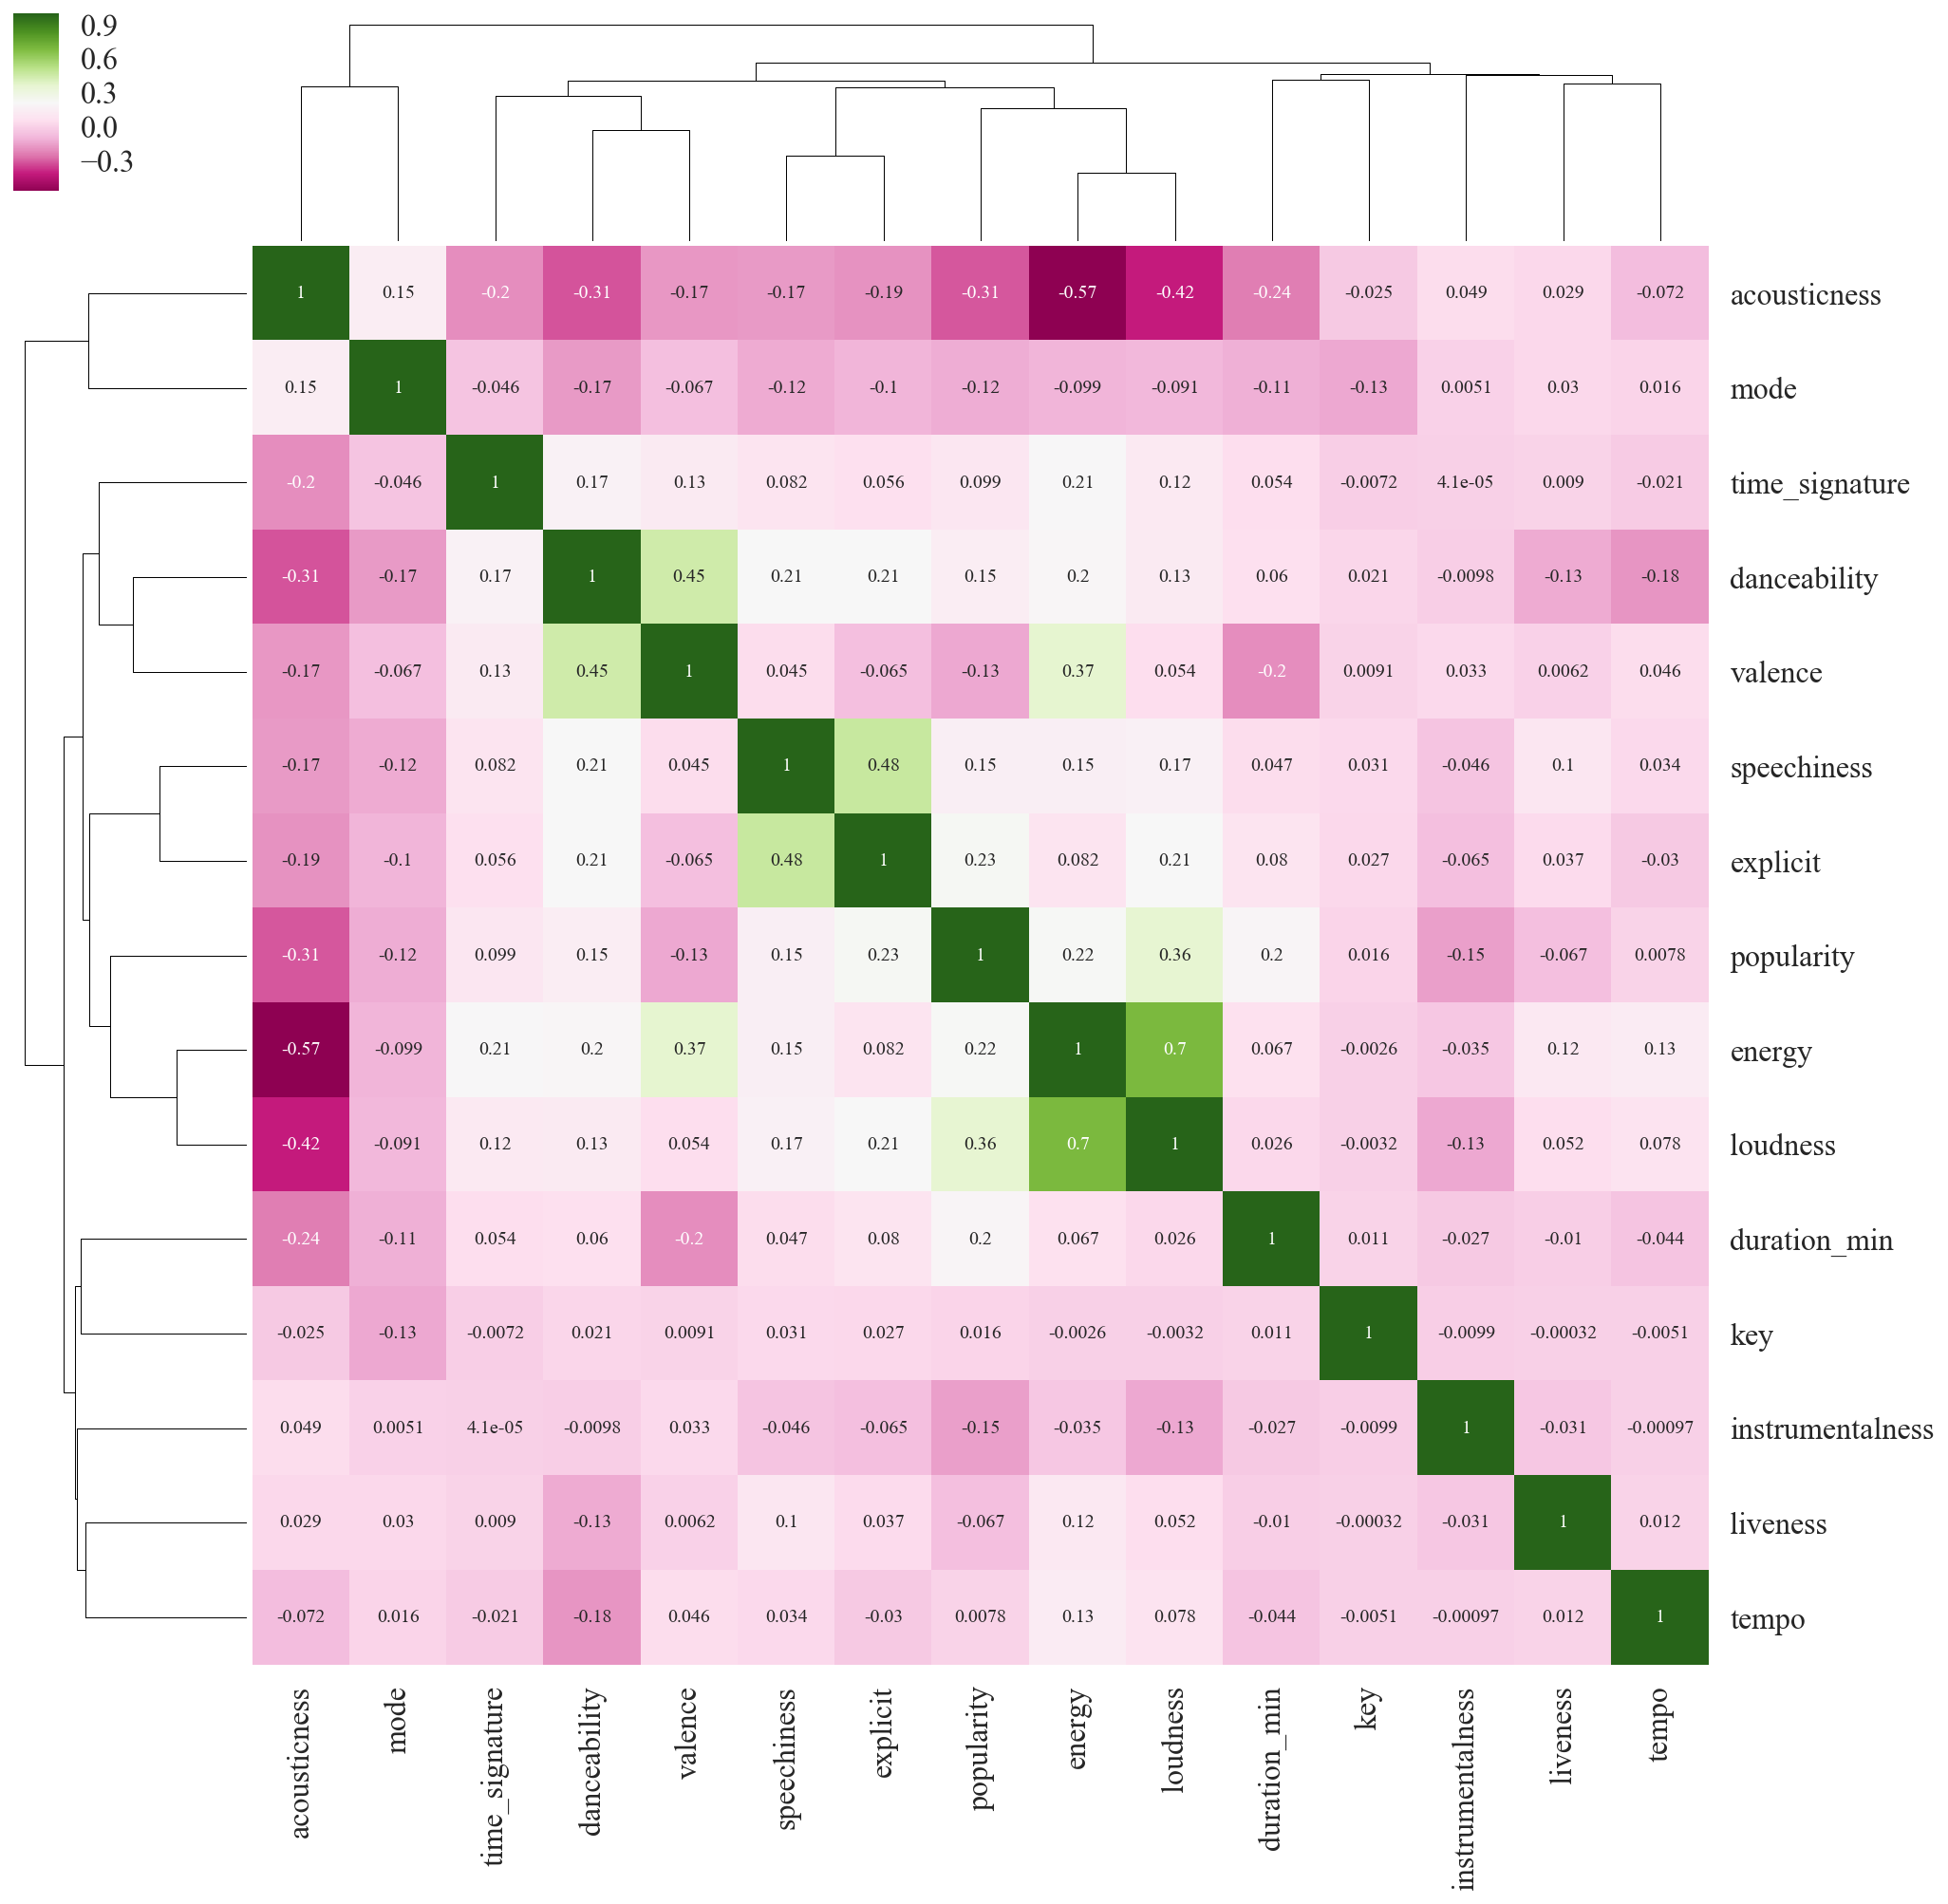

In [17]:
columns = ['acousticness', 'danceability', 'duration_min', 'energy',
           'instrumentalness', 'liveness', 'loudness', 'popularity',
           'speechiness', 'tempo', 'valence', 'time_signature', 'mode',
           'key', 'explicit']
df_scatter = df[columns]
sns.clustermap(df_scatter.corr(), cmap='PiYG', annot=True, figsize=(16,16))

## Bivariate distributions

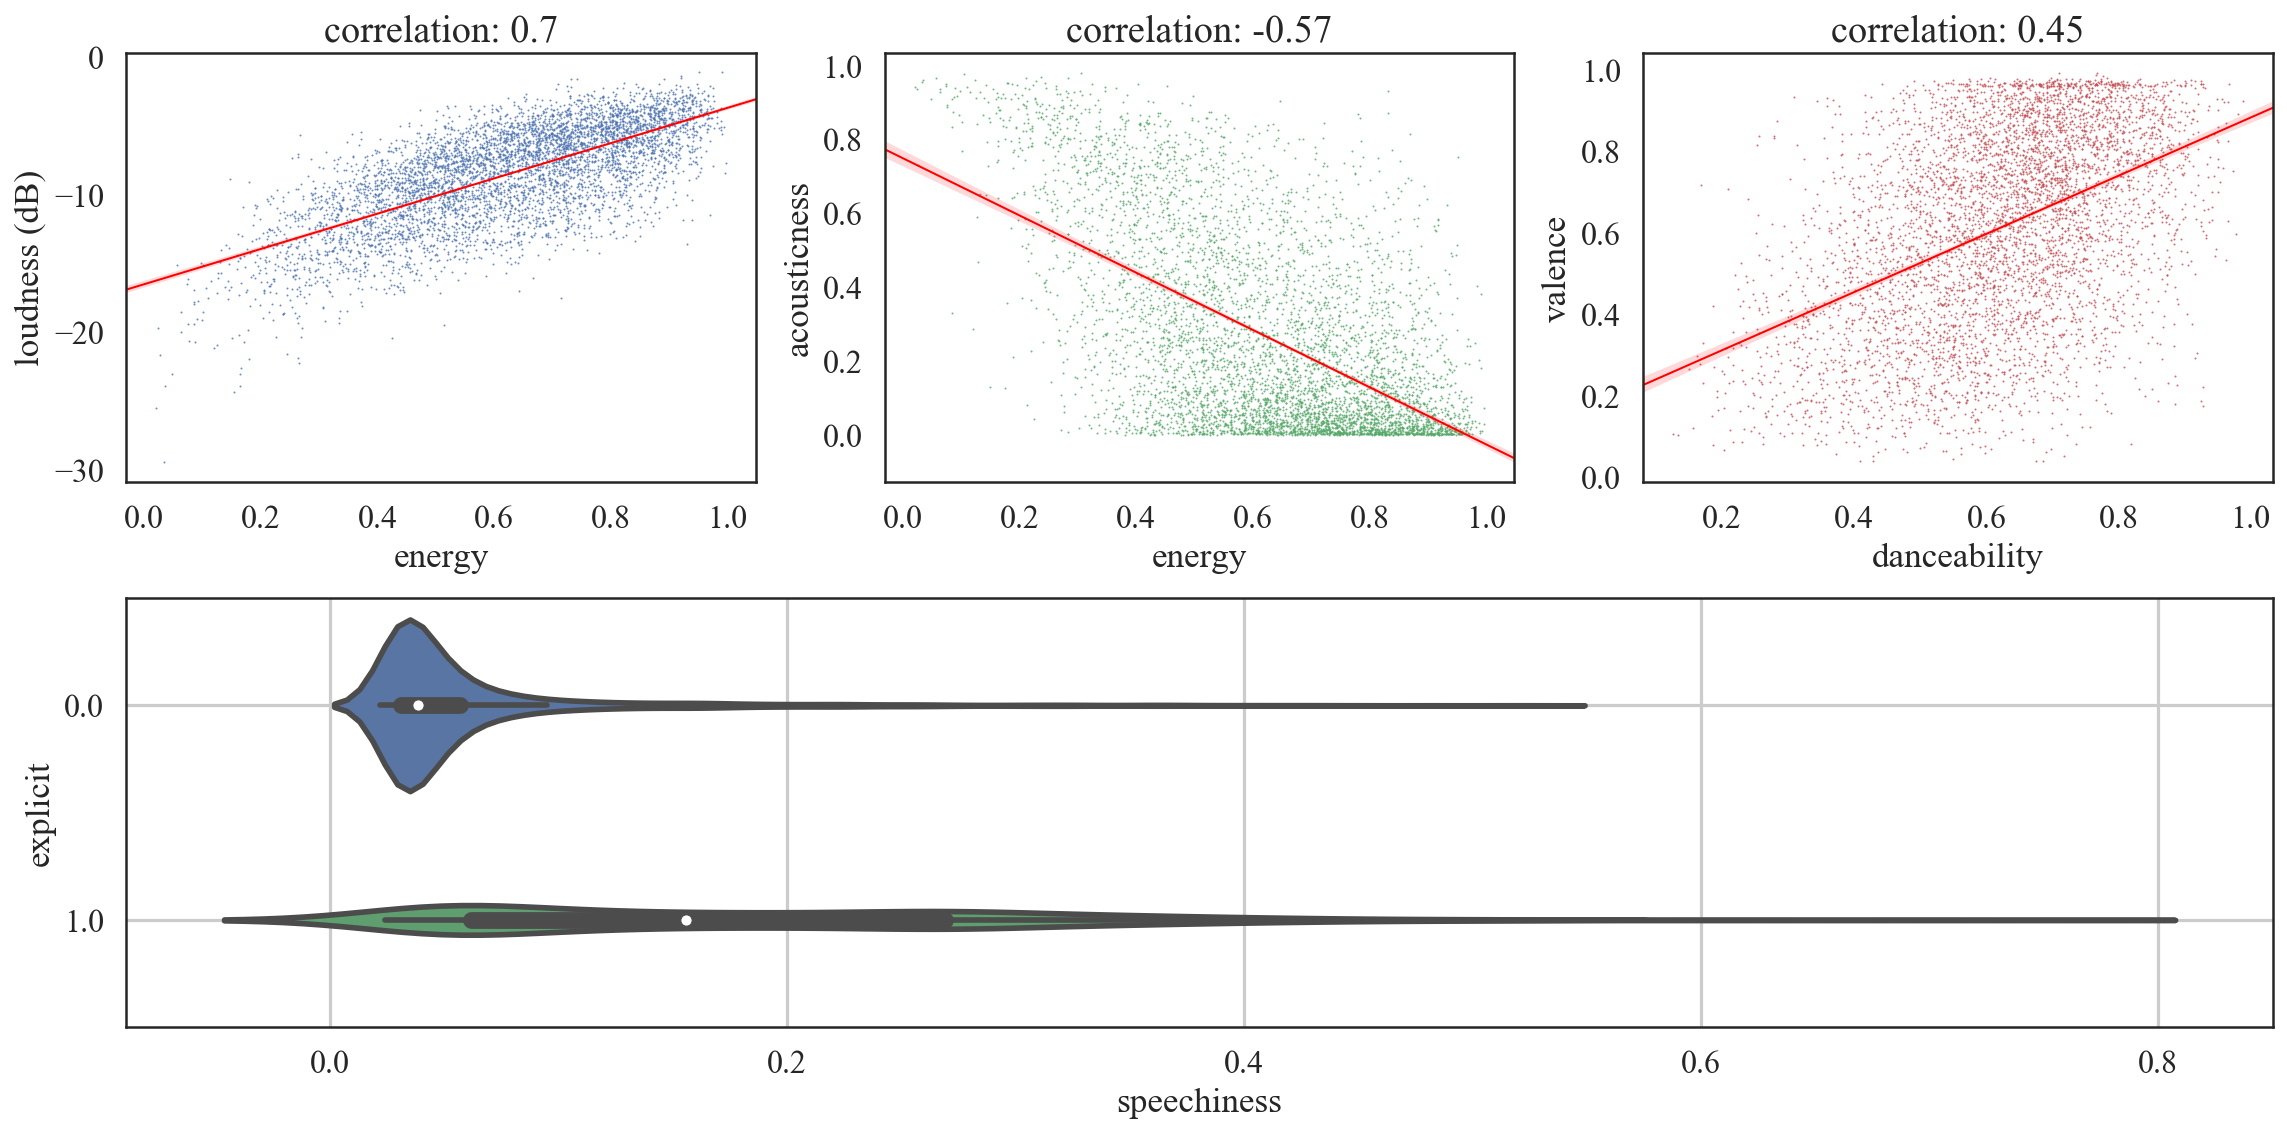

In [13]:
# generate subplot axes
axes = list()
plt.figure(figsize = (16,8))
grid_positions = [231, 232, 233, 212]
for position in grid_positions:
    axes.append(plt.subplot(position))
    
feature_pairs = [('energy', 'loudness'), ('energy', 'acousticness'),
                 ('danceability', 'valence')]

# generate upper scatter plots
for (x, y), ax in zip(feature_pairs, axes[:3]):
    r = np.corrcoef(df[x].dropna(), df[y].dropna())[0][1]
    sns.regplot(data=df, x=x, y=y, line_kws= {'linewidth': 1, 'color': 'red'},
                scatter_kws={'s': 1}, label='test', ax=ax)
    ax.set(title='correlation: {:.2}'.format(r))
axes[0].set(ylabel='loudness (dB)') 

# generate lower violin plot
sns.violinplot(data=df, x='speechiness', y='explicit', orient='horizontal',
               split=True, ax=axes[3])
axes[3].grid(True)

plt.tight_layout()